<a href="https://www.kaggle.com/code/mohamedashrefbna/tunisian-property-analysis-crisp-dm?scriptVersionId=231928857" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Key insight into Tunisia using data visualization
This Kaggle project delves into the fascinating world of Tunisian property prices, using data analysis and visualization to uncover hidden trends and insights, using a free data set scraped from Tayara.tn

---

# CRISP-DM Process for Tunisian Property Price Analysis

We will follow the Cross-Industry Standard Process for Data Mining (CRISP-DM) to structure our analysis and potential modeling efforts.

## 1. Business Understanding

*   **Business Objectives:**
    *   Primary: Develop a model to accurately predict property prices in Tunisia based on available features (category, room count, bathroom count, size, type, city, region).
    *   Secondary: Understand the key drivers influencing property prices in Tunisia and identify the most predictive features.
*   **Data Mining Goals:**
    *   Predict the `price` (or potentially `log_price`) for property listings.
    *   Evaluate model performance using metrics like Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²).
    *   Identify features strongly correlated with high/low prices.
*   **Project Plan:** Follow the six phases of CRISP-DM, documenting findings at each stage.

## 2. Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Added imports for RandomizedSearchCV, KMeans, and SHAP
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import shap

# Keras imports for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler


print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices("GPU")))

TensorFlow version: 2.17.1
Num GPUs Available: 0


In [2]:
# dataset in the same folder as notebook folder
df = pd.read_csv("/kaggle/input/property-prices-in-tunisia/Property Prices in Tunisia.csv")
df.head()

,category,room_count,bathroom_count,size,type,price,city,region,log_price
0,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,100000.0,Ariana,Raoued,5.000000
1,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,316000.0,Ariana,Autres villes,5.499687
2,Appartements,2.0,1.0,80.0,À Louer,380.0,Ariana,Autres villes,2.579784
3,Locations de vacances,1.0,1.0,90.0,À Louer,70.0,Ariana,Autres villes,1.845098
4,Appartements,2.0,2.0,113.0,À Vendre,170000.0,Ariana,Ariana Ville,5.230449


In [3]:
print("Size: ", df.size)
print("Shape:", df.shape)

Size:  114732
Shape: (12748, 9)


In [4]:
# Display data types and non-null counts
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12748 entries, 0 to 12747
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        12748 non-null  object 
 1   room_count      12748 non-null  float64
 2   bathroom_count  12748 non-null  float64
 3   size            12748 non-null  float64
 4   type            12748 non-null  object 
 5   price           12748 non-null  float64
 6   city            12748 non-null  object 
 7   region          12748 non-null  object 
 8   log_price       12748 non-null  float64
dtypes: float64(5), object(4)
memory usage: 896.5+ KB


In [5]:
# Display summary statistics for all columns
print("\nDescriptive Statistics:")
print(df.describe(include="all"))

# Replacing the too long name with a more succinct alternative
df["category"] = df["category"].replace(
    to_replace="Magasins, Commerces et Locaux industriels", value="Locaux industriels"
)
print(df["category"].unique())


Descriptive Statistics:
            category    room_count  bathroom_count          size      type  \
count          12748  12748.000000    12748.000000  12748.000000     12748   
unique             7           NaN             NaN           NaN         2   
top     Appartements           NaN             NaN           NaN  À Vendre   
freq            4700           NaN             NaN           NaN      7758   
mean             NaN      1.759649        0.759884    130.896219       NaN   
std              NaN      2.171468        1.264812    184.074990       NaN   
min              NaN     -1.000000       -1.000000     -1.000000       NaN   
25%              NaN     -1.000000       -1.000000     -1.000000       NaN   
50%              NaN      2.000000        1.000000     95.000000       NaN   
75%              NaN      3.000000        1.000000    150.000000       NaN   
max              NaN     20.000000       10.000000   2000.000000       NaN   

               price   city         re

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


### Early Outlier Removal (IQR Method)
We identify and remove outliers in key numerical columns early to prevent them from skewing visualizations and subsequent analyses.
The Interquartile Range (IQR) method is used. Values outside Q1 - 1.5*IQR and Q3 + 1.5*IQR are considered outliers and removed.
Note: The placeholder '-1' values are replaced with NaN *before* calculating IQR to avoid incorrect results.

In [6]:
# Define numerical columns for outlier removal
numerical_cols_outlier = ["room_count", "bathroom_count", "size", "price"]
iqr_multiplier = 1.5  # Standard multiplier for IQR outlier detection

# --- IMPORTANT: Replace -1 with NaN *before* calculating quantiles ---
print("\nReplacing -1 placeholders with NaN for IQR calculation...")
for col in numerical_cols_outlier:
    # Check if the column exists before attempting replacement
    if col in df.columns:
        df[col] = df[col].replace(-1, np.nan)
    else:
        print(f"Warning: Column '{col}' not found for -1 replacement.")

print(f"Applying IQR Outlier Removal (multiplier={iqr_multiplier})...")
original_shape = df.shape
print(f"Original DataFrame shape: {original_shape}")

df_cleaned = df.copy()  # Work on a copy initially

# Apply IQR filter iteratively
for col in numerical_cols_outlier:
    if col not in df_cleaned.columns or df_cleaned[col].isnull().all():
        print(f"Skipping IQR for column '{col}' as it's not present or all NaN.")
        continue

    # Calculate Q1, Q3, and IQR, skipping NaN values
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Filter out outliers for the current column
    initial_count = len(df_cleaned)
    df_cleaned = df_cleaned[
        (df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)
        | df_cleaned[col].isnull()
    ]
    removed_count = initial_count - len(df_cleaned)
    if removed_count > 0:
        print(
            f" - Removed {removed_count} outliers based on {col} (Bounds: {lower_bound:.2f} - {upper_bound:.2f})"
        )

# Assign the cleaned data back to df
df = df_cleaned
cleaned_shape = df.shape
rows_removed = original_shape[0] - cleaned_shape[0]

print(f"\nDataFrame shape after IQR outlier removal: {cleaned_shape}")
print(f"Total rows removed: {rows_removed}")

# Display summary statistics after outlier removal
print("\nDescriptive Statistics after Outlier Removal:")
print(df.describe(include="all"))


Replacing -1 placeholders with NaN for IQR calculation...
Applying IQR Outlier Removal (multiplier=1.5)...
Original DataFrame shape: (12748, 9)
 - Removed 866 outliers based on room_count (Bounds: 0.50 - 4.50)
 - Removed 2001 outliers based on bathroom_count (Bounds: 1.00 - 1.00)
 - Removed 614 outliers based on size (Bounds: -9.00 - 215.00)
 - Removed 868 outliers based on price (Bounds: -298375.00 - 499025.00)

DataFrame shape after IQR outlier removal: (8399, 9)
Total rows removed: 4349

Descriptive Statistics after Outlier Removal:
            category   room_count  bathroom_count         size      type  \
count           8399  5736.000000          5736.0  5736.000000      8399   
unique             7          NaN             NaN          NaN         2   
top     Appartements          NaN             NaN          NaN  À Vendre   
freq            3654          NaN             NaN          NaN      4699   
mean             NaN     2.141039             1.0    98.947699       NaN   
s

invalid value encountered in greater_equal
invalid value encountered in less_equal
invalid value encountered in greater_equal
invalid value encountered in less_equal
invalid value encountered in greater_equal
invalid value encountered in less_equal
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


# Most popular category for real estate in Tunisia

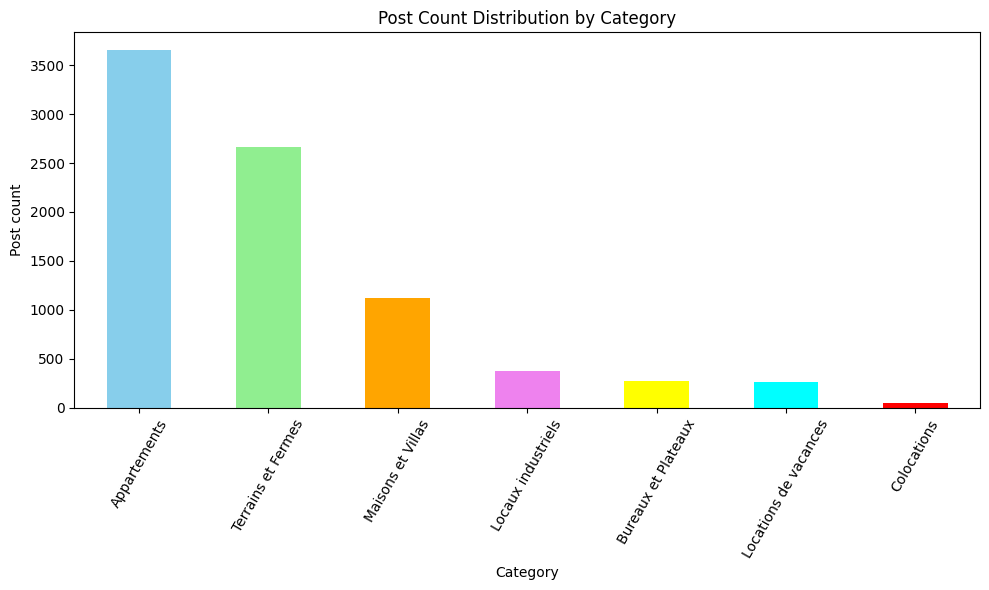

In [7]:
colors = ["skyblue", "lightgreen", "orange", "violet", "yellow", "cyan", "red"]

plt.figure(figsize=(10, 6))
df.category.value_counts().plot(kind="bar", y="count", width=0.5, color=colors)
plt.xlabel("Category")
plt.ylabel("Post count")
plt.xticks(rotation=60)
plt.title("Post Count Distribution by Category")
plt.tight_layout()
plt.show()

# Cities with the most real estate sale posts

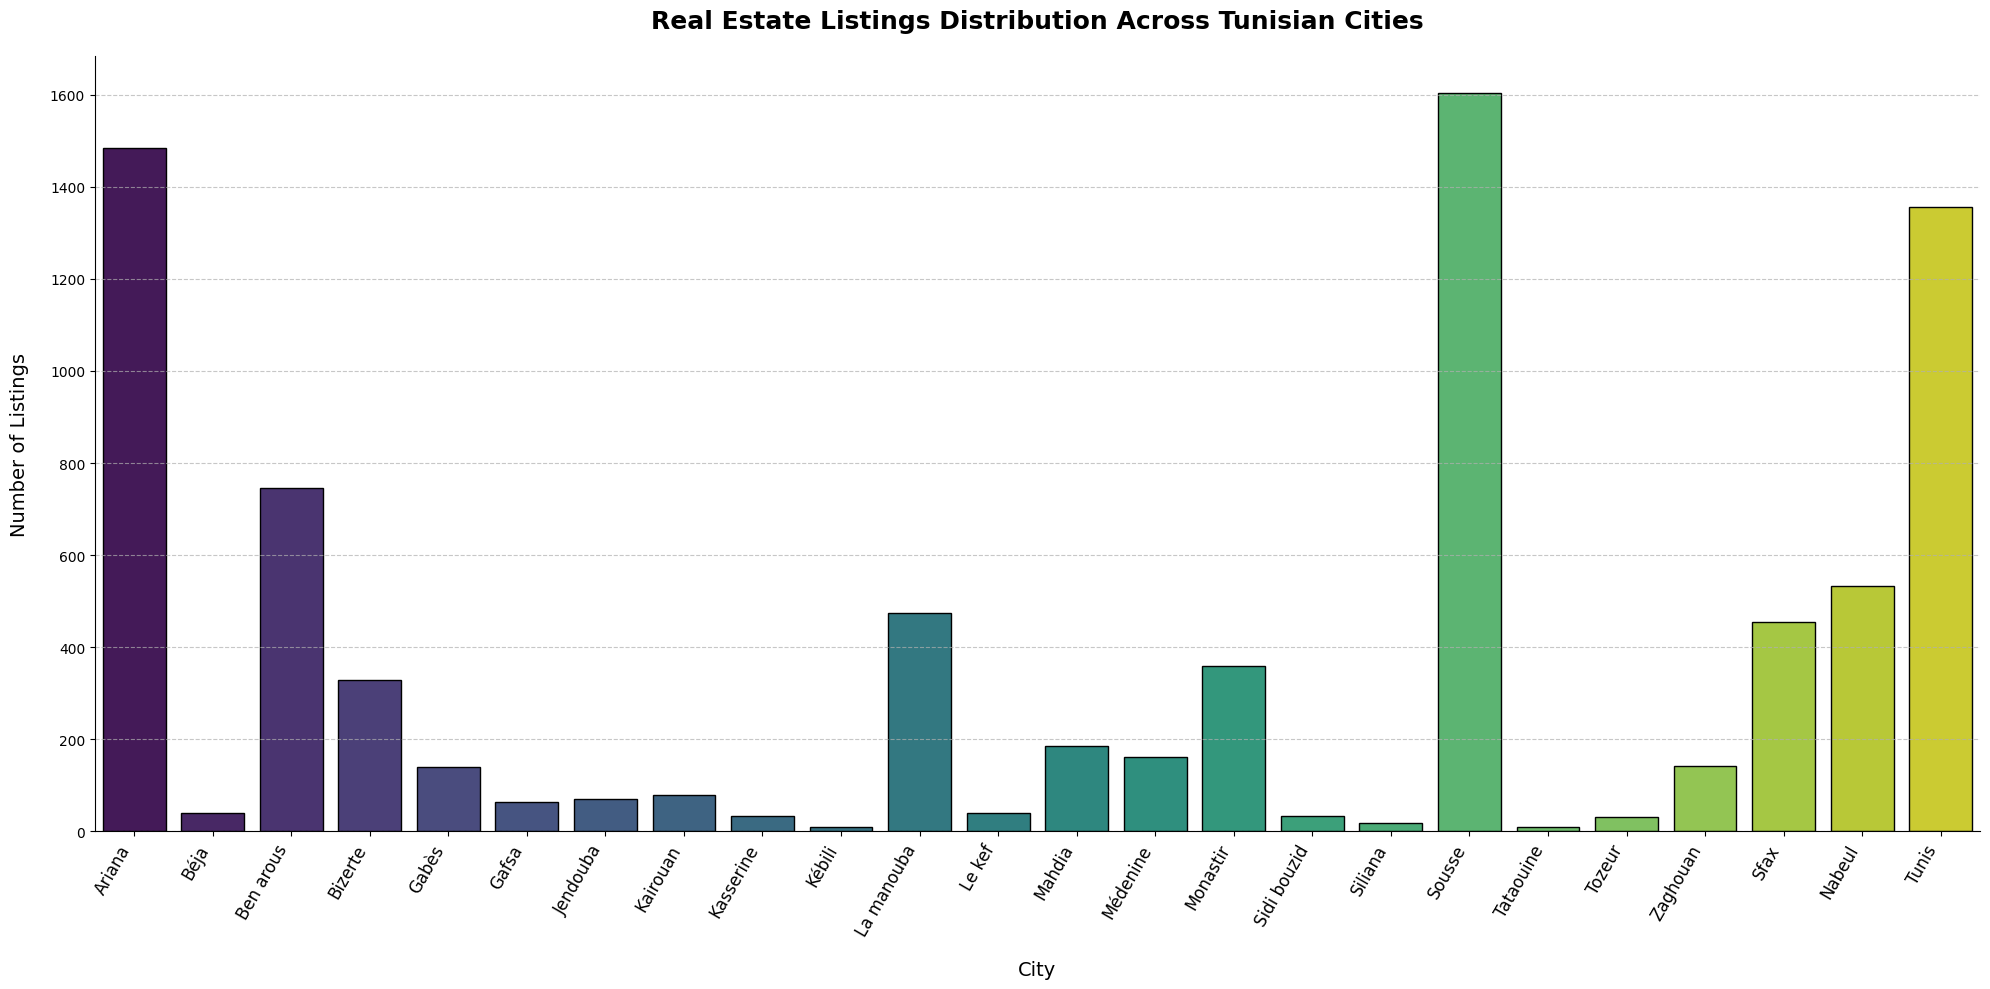

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))

# Create countplot with improved styling
sns.countplot(data=df, x="city", ax=ax, palette="viridis", edgecolor="black")

# Add title and labels
ax.set_title("Real Estate Listings Distribution Across Tunisian Cities", 
             fontsize=18, pad=20, weight='bold')
ax.set_xlabel("City", fontsize=14, labelpad=15)
ax.set_ylabel("Number of Listings", fontsize=14, labelpad=15)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', fontsize=12)

# Add gridlines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Remove top and right spines for cleaner look
sns.despine()

# Adjust layout
plt.tight_layout()

In [9]:
df["city"][df.type == "À Louer"].unique()

array(['Ariana', 'Béja', 'Ben arous', 'Bizerte', 'Gabès', 'Gafsa',
       'Jendouba', 'Kairouan', 'Kasserine', 'Kébili', 'La manouba',
       'Le kef', 'Mahdia', 'Médenine', 'Monastir', 'Sidi bouzid',
       'Siliana', 'Sousse', 'Tozeur', 'Zaghouan', 'Sfax', 'Nabeul',
       'Tunis'], dtype=object)

# Distribution of "For Sale" and "For Rent" posts per city

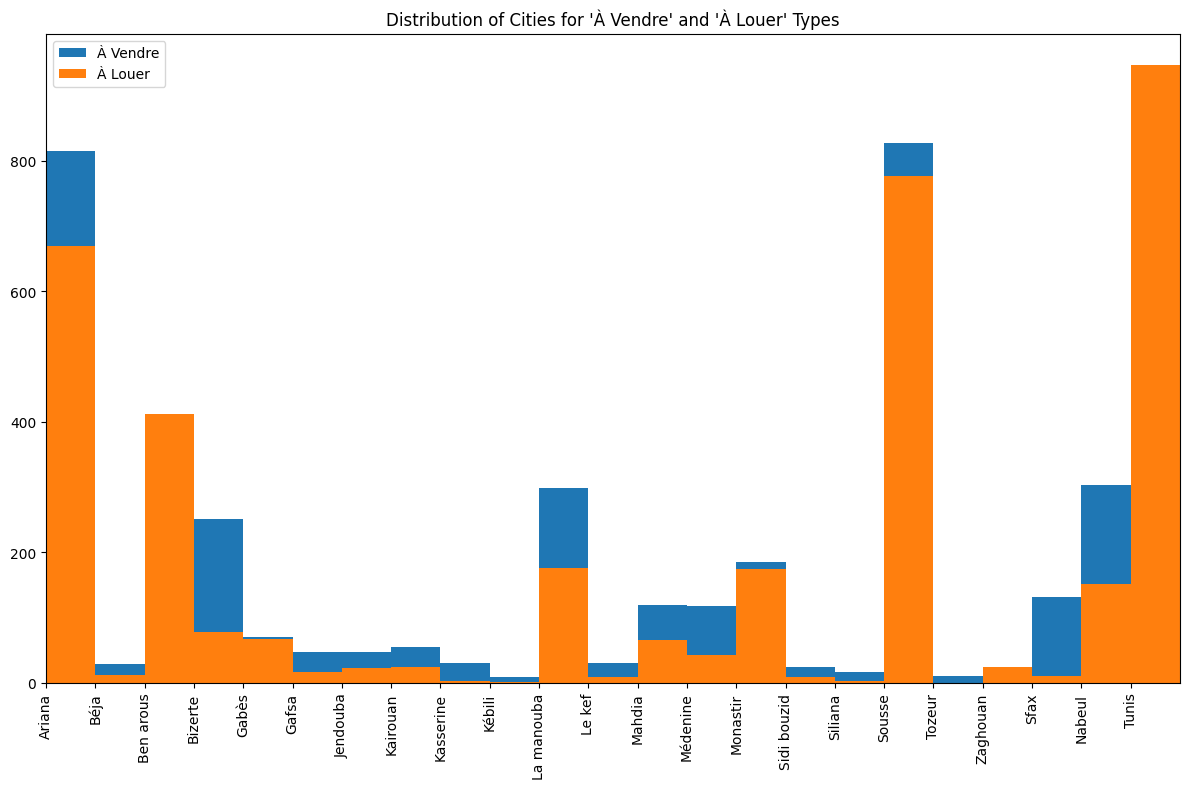

In [10]:
# Define city names as tick labels
city_names = df["city"][df.type == "À Louer"].unique()

# Create figure and axes
fig, axs = plt.subplots(figsize=(12, 8))

# Generate histograms with labels
axs.hist(df["city"][df.type == "À Vendre"], bins=23, label="À Vendre")
axs.hist(df["city"][df.type == "À Louer"], bins=23, label="À Louer")

# Set fixed tick locations and labels with rotation
axs.set_xlim(0, len(city_names))
xticks = range(len(city_names))
locator = FixedLocator(xticks)
axs.xaxis.set_major_locator(locator)
axs.set_xticklabels(city_names, rotation=90)

# Add legend and title
axs.legend()
axs.set_title("Distribution of Cities for 'À Vendre' and 'À Louer' Types")

# Rotate x-axis labels for better readability
# This plt.xticks call might be redundant or conflict with axs.set_xticklabels above.
# Let's comment it out for now as axs.set_xticklabels already handles rotation.
# plt.xticks(rotation=60, ha="left")

plt.tight_layout()
plt.show()

In [11]:
# Resizing dataset
# Note: The original df_app filtering might be premature. We'll likely use more columns later.
# Let's keep the original df for subsequent steps for now.
# df_app = df.filter(["category", "price", "size", "type"], axis=1)
# print(df_app)

# Cities with most real estate posts, sorted

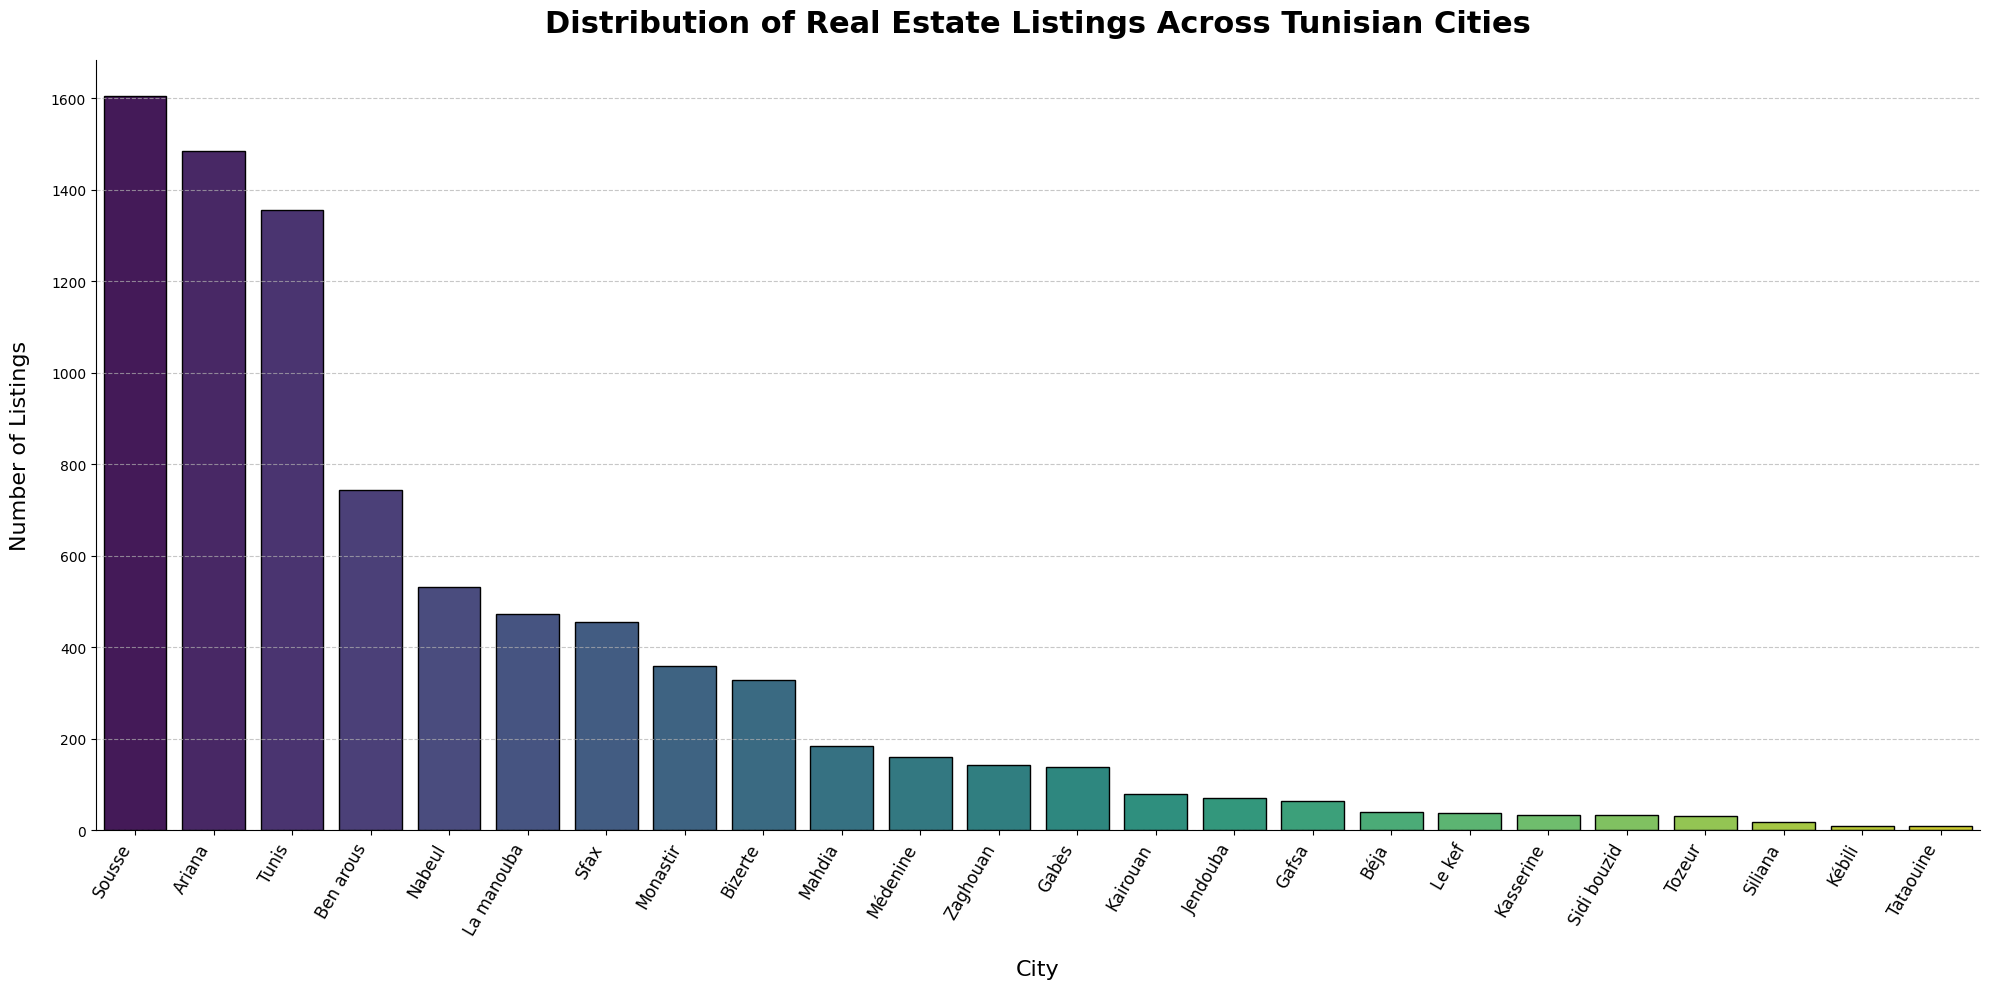

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))

# Create countplot with improved styling - KEEPING THE ORIGINAL SORTING
sns.countplot(data=df, x="city", ax=ax, order=df.city.value_counts().index, 
              palette="viridis", edgecolor="black")

# Add title with styling
ax.set_title("Distribution of Real Estate Listings Across Tunisian Cities", 
             fontsize=22, pad=20, fontweight='bold')

# Improve axis labels
ax.set_xlabel("City", fontsize=16, labelpad=15)
ax.set_ylabel("Number of Listings", fontsize=16, labelpad=15)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', fontsize=12)

# Add gridlines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Remove top and right spines for cleaner look
sns.despine()

# Adjust layout
plt.tight_layout()

# Size vs. Price of real estate posts visualized
We can spot a few outliers too

**Why use the logarithm of price ?**

It helps to visualize overall trends and relationships more clearly, especially when comparing prices across different ranges or property types.



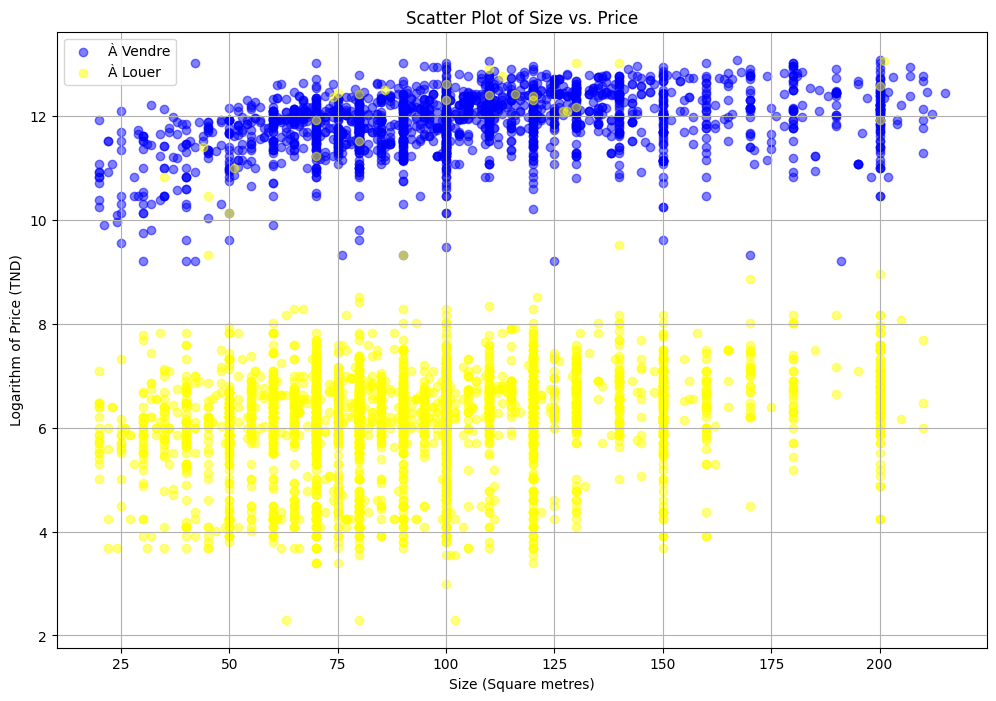

In [13]:
# Creating a scatter plot
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

# Filter out potential zero or negative prices before taking log
df_vendre = df[(df.type == "À Vendre") & (df.price > 0)]
df_louer = df[(df.type == "À Louer") & (df.price > 0)]

plt.scatter(
    df_vendre["size"],
    np.log(df_vendre["price"]),  # Use numpy's log directly
    alpha=0.5,
    color="blue",
    label="À Vendre",
)
plt.scatter(
    df_louer["size"],
    np.log(df_louer["price"]),  # Use numpy's log directly
    alpha=0.5,
    color="yellow",
    label="À Louer",
)
# Adding labels and title
plt.xlabel("Size (Square metres)")
plt.ylabel("Logarithm of Price (TND)")  # Log was used to help focus on changes
plt.title("Scatter Plot of Size vs. Price")
plt.legend()

plt.grid(True)  # Adding grid lines
plt.show()

### Data Quality: Missing Values & Initial Imputation
The `.info()` output above shows missing values (indicated by counts less than the total 12748 entries) in `room_count`, `bathroom_count`, and `size`.
The `.describe()` output confirms the source CSV used -1 for imputation, as seen in the 'min' row for these columns.
We will need to address this imputation strategy in the Data Preparation phase.

### Data Exploration: Feature Distributions and Relationships

#### Categorical Feature Exploration

In [14]:
# Value counts for Category (already done)
print("\nCategory Value Counts:")
print(df.category.value_counts())


Category Value Counts:
category
Appartements             3654
Terrains et Fermes       2663
Maisons et Villas        1121
Locaux industriels        378
Bureaux et Plateaux       270
Locations de vacances     264
Colocations                49
Name: count, dtype: int64


In [15]:
# Value counts for Type
print("\nType Value Counts:")
print(df.type.value_counts())


Type Value Counts:
type
À Vendre    4699
À Louer     3700
Name: count, dtype: int64


In [16]:
# Unique values for City (already explored via plots)
print("\nNumber of Unique Cities:", df.city.nunique())
# print(df.city.unique()) # Uncomment to see all city names


Number of Unique Cities: 24


In [17]:
# Unique values for Region
print("\nNumber of Unique Regions:", df.region.nunique())
print("\nRegion Value Countsterminal:")
print(df.region.value_counts())


Number of Unique Regions: 236

Region Value Countsterminal:
region
Autres villes    1511
Hammamet          355
Sahloul           230
La Marsa          222
Hammam Sousse     220
                 ... 
Ghardimaou          1
Sidi Aïch           1
El Guettar          1
Métlaoui            1
Séjoumi             1
Name: count, Length: 236, dtype: int64


#### Numerical Feature Exploration (Distributions & Outliers)
We plot boxplots for numerical features to understand their distribution and identify potential outliers.


Generating boxplots for 'size' and 'price' to spot outliers...


invalid value encountered in greater


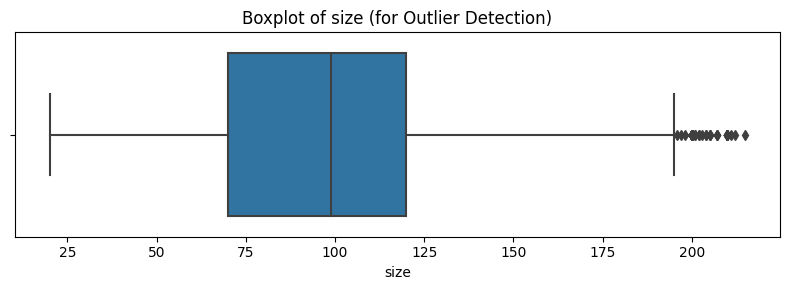

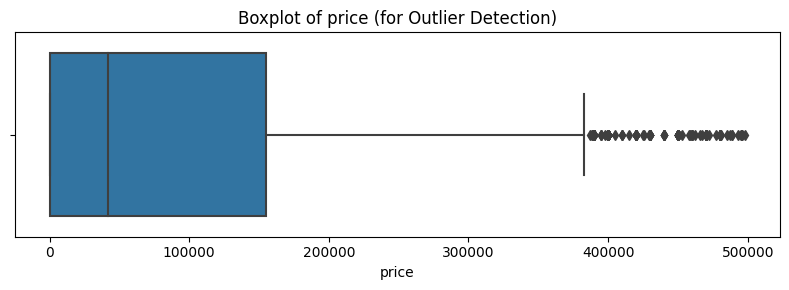

Boxplot generation complete.


In [18]:
# Select numerical columns (excluding log_price for now, and handling the imputed -1)
# Focus on 'size' and 'price' for outlier visualization via boxplots
numerical_cols_for_outliers = ["size", "price"]

print("\nGenerating boxplots for 'size' and 'price' to spot outliers...")

# Loop through selected numerical columns and create boxplots
for col in numerical_cols_for_outliers:
    # Filter out the imputed -1 values for visualization
    data_filtered = df[df[col] > -1][col]

    if data_filtered.empty:
        print(f"Skipping boxplot for {col} as there is no data after filtering -1.")
        continue

    # --- Boxplot ---
    plt.figure(figsize=(8, 3))  # Create a new figure for the boxplot
    sns.boxplot(x=data_filtered)
    plt.title(f"Boxplot of {col} (for Outlier Detection)")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()  # Show the boxplot

print("Boxplot generation complete.")

#### Correlation Analysis
Let's examine the correlation between numerical features. We use the log of price as it often shows clearer linear relationships after transformation.

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


invalid value encountered in greater
Boolean Series key will be reindexed to match DataFrame index.
invalid value encountered in greater
Boolean Series key will be reindexed to match DataFrame index.
invalid value encountered in less


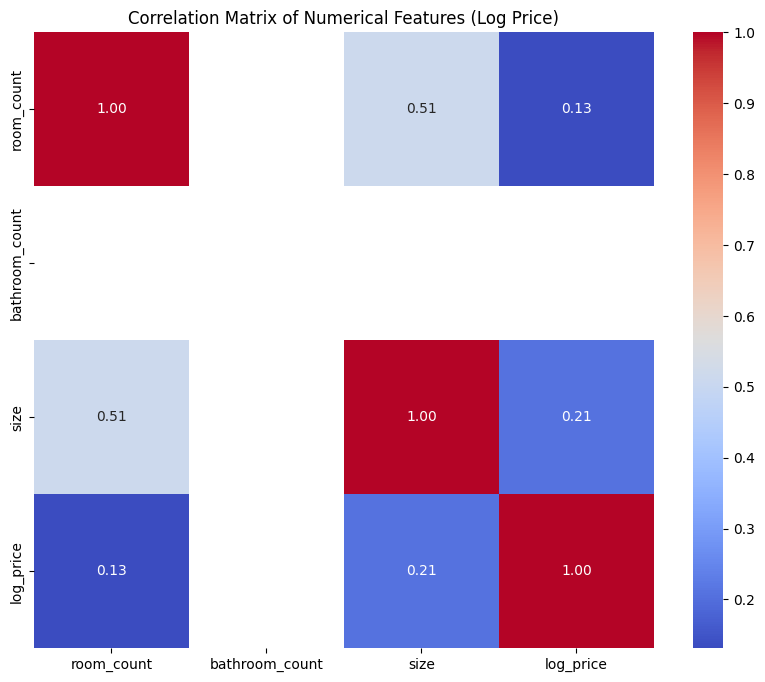

In [19]:
# Ensure log_price column exists or create it (handle potential zero/negative prices)
df["log_price"] = np.log(
    df["price"].replace(0, np.nan)
)  # Replace 0 with NaN before log
df["log_price"].fillna(
    df["log_price"].median(), inplace=True
)  # Basic imputation for NaN log_price

# Select numerical columns for correlation analysis (including log_price, excluding original price)
# Also excluding the imputed -1 values for a more meaningful correlation
corr_df = df[df["room_count"] > -1][df["bathroom_count"] > -1][df["size"] > -1]
corr_cols = ["room_count", "bathroom_count", "size", "log_price"]
correlation_matrix = corr_df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features (Log Price)")
plt.show()

### Data Understanding Summary:
*   **Data Source:** Scraped from Tayara.tn.
*   **Size:** 12,748 listings, 9 initial columns (`category`, `room_count`, `bathroom_count`, `size`, `type`, `price`, `city`, `region`, `log_price` - we added `log_price`).
*   **Data Types:** Mix of categorical (`category`, `type`, `city`, `region`) and numerical. `log_price` was added.
*   **Data Quality Issues:**
    *   Missing Values: `room_count`, `bathroom_count`, `size` have missing values imputed as -1 in the original CSV.
    *   Outliers: Significant outliers detected in `price` and `size`. Log transformation of price helps mitigate price outliers' impact in some visualizations and analyses.
    *   Consistency: `category` names were long; one was shortened. `city` and `region` have many unique values.
*   **Exploration Insights:**
    *   Distributions: Numerical features are generally right-skewed. `price` is highly skewed.
    *   Relationships: Scatter plots and correlation matrix (using `log_price`) show expected positive correlations between price and size/room count/bathroom count. `size` shows the strongest correlation with `log_price`.
    *   Categorical Features: Apartments are the most common category. Certain cities have significantly more listings than others.
*   **Next Steps:** Proceed to Data Preparation to handle missing values, outliers, encode categorical features, and prepare data for modeling.

## 3. Data Preparation
In this phase, we clean and transform the data to make it suitable for modeling.
This now includes feature engineering *after* the early outlier removal step.

### Feature Engineering
Create a 'price_per_sqm' feature and recalculate 'log_price' based on the outlier-cleaned data.

In [20]:
# Start processing from the outlier-cleaned DataFrame
df_processed = df.copy()

# Note: -1 placeholders were already replaced with NaN during the IQR step.

# Add price_per_sqm feature (handle potential division by zero or near-zero size)
# Replace 0 or very small sizes with NaN before division
print("Creating 'price_per_sqm' feature...")
df_processed["size_for_calc"] = df_processed["size"].replace(0, np.nan)
# Ensure price is also positive and not NaN (it might be NaN if original price was NaN/0)
df_processed["price_for_calc"] = df_processed["price"].replace(0, np.nan)
# Need to handle cases where price is NaN after outlier removal
df_processed["price_for_calc"].dropna(inplace=True)

df_processed["price_per_sqm"] = (
    df_processed["price_for_calc"] / df_processed["size_for_calc"]
)

# Impute any resulting NaNs in price_per_sqm (e.g., from size=0 or price=NaN) with the median
# Calculate median on the potentially smaller df_processed after NaNs in price_for_calc were dropped
price_per_sqm_median = df_processed["price_per_sqm"].median()
print(f"Median price_per_sqm (used for imputation): {price_per_sqm_median:.2f}")
df_processed["price_per_sqm"].fillna(price_per_sqm_median, inplace=True)

# Recalculate log_price based on the potentially capped and non-negative price
print("Recalculating 'log_price' based on processed price...")
# Ensure we only take log of positive prices after outlier removal
df_processed["price_positive"] = df_processed["price"].apply(
    lambda x: x if pd.notna(x) and x > 0 else np.nan
)
df_processed["log_price"] = np.log(df_processed["price_positive"])
# Impute log_price NaNs (from original price=NaN or price<=0) with the median of calculated log_prices
log_price_median = df_processed[
    "log_price"
].median()  # Recalculate median based on current data
df_processed["log_price"].fillna(log_price_median, inplace=True)

# Drop temporary calculation columns
df_processed = df_processed.drop(
    columns=["size_for_calc", "price_for_calc", "price_positive"]
)

print("Feature engineering complete.")
print("\nInfo after processing:")
df_processed.info()

Creating 'price_per_sqm' feature...
Median price_per_sqm (used for imputation): 10.00
Recalculating 'log_price' based on processed price...
Feature engineering complete.

Info after processing:
<class 'pandas.core.frame.DataFrame'>
Index: 8399 entries, 0 to 12747
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   category        8399 non-null   object 
 1   room_count      5736 non-null   float64
 2   bathroom_count  5736 non-null   float64
 3   size            5736 non-null   float64
 4   type            8399 non-null   object 
 5   price           8399 non-null   float64
 6   city            8399 non-null   object 
 7   region          8399 non-null   object 
 8   log_price       8399 non-null   float64
 9   price_per_sqm   8399 non-null   float64
dtypes: float64(6), object(4)
memory usage: 979.8+ KB


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [21]:
# Define features (X) and target (y) using the processed DataFrame
# We will predict log_price and transform back later if needed.
# Exclude original 'price' column from features, but include 'price_per_sqm'
features = [
    "category",
    "room_count",  # Will be imputed later
    "bathroom_count",  # Will be imputed later
    "size",  # Capped size, will be imputed later
    "price_per_sqm",  # New feature, imputed Nans
    "type",
    "city",
    "region",
]
target = "log_price"  # Recalculated log_price

X = df_processed[features].copy()
y = df_processed[target].copy()

print("\nFeatures selected for modeling:")
print(X.columns.tolist())
print("\nTarget variable:", target)

# Display NaN counts in selected features before splitting (these will be handled by the pipeline)
print("\nNaN counts in features going into split:")
print(X.isnull().sum())


Features selected for modeling:
['category', 'room_count', 'bathroom_count', 'size', 'price_per_sqm', 'type', 'city', 'region']

Target variable: log_price

NaN counts in features going into split:
category             0
room_count        2663
bathroom_count    2663
size              2663
price_per_sqm        0
type                 0
city                 0
region               0
dtype: int64


In [22]:
# Split data into Training and Testing sets (80/20 split)
# Stratification is not typically used for regression targets
print("Splitting data into training and testing sets (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Data splitting complete.")

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Splitting data into training and testing sets (80/20)...
Data splitting complete.
Training set shape: (6719, 8)
Test set shape: (1680, 8)


### Preprocessing Steps
We create preprocessing pipelines for numerical and categorical features.
This involves:
1.  **Imputation:** Filling missing numerical values (NaNs created from -1) using the median of the training data.
2.  **Scaling:** Standardizing numerical features (mean 0, variance 1) based on the training data.
3.  **Encoding:** Converting categorical features into numerical format using One-Hot Encoding based on the training data (handling unknown categories found in the test set).

In [23]:
# Identify numerical and categorical columns
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

print("\nNumerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

# Create preprocessing pipelines
numerical_pipeline = Pipeline(
    steps=[
        (
            "imputer",
            SimpleImputer(strategy="median"),
        ),  # Impute missing values with median
        ("scaler", StandardScaler()),  # Scale numerical features
    ]
)

categorical_pipeline = Pipeline(
    steps=[
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        )  # One-hot encode categorical features
    ]
)

# Create a column transformer to apply different pipelines to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features),
    ],
    remainder="passthrough",  # Keep other columns (if any) - should be none here
)


Numerical Features: ['room_count', 'bathroom_count', 'size', 'price_per_sqm']
Categorical Features: ['category', 'type', 'city', 'region']


In [24]:
# Apply the preprocessing steps to the training and testing data
# NOTE: The preprocessor is FIT ONLY on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding for better interpretability later
# Need to handle potential unknown categories if using sparse matrix
feature_names_out = preprocessor.get_feature_names_out()

# Convert processed arrays back to DataFrames (optional, but can be useful)
X_train_processed_df = pd.DataFrame(
    X_train_processed, columns=feature_names_out, index=X_train.index
)
X_test_processed_df = pd.DataFrame(
    X_test_processed, columns=feature_names_out, index=X_test.index
)

print("\nShape of processed training data:", X_train_processed.shape)
print("Shape of processed testing data:", X_test_processed.shape)
print("\nFirst 5 rows of processed training data:")
print(X_train_processed_df.head())


Shape of processed training data: (6719, 262)
Shape of processed testing data: (1680, 262)

First 5 rows of processed training data:
       num__room_count  num__bathroom_count  num__size  num__price_per_sqm  \
11008         1.244492                  0.0  -0.739185           -0.486764   
3858         -0.129213                  0.0  -0.018995           -0.493877   
1401          1.244492                  0.0   0.200193            1.278130   
6582         -0.129213                  0.0  -0.018995           -0.493877   
12709        -0.129213                  0.0   0.043630           -0.497434   

       cat__category_Appartements  cat__category_Bureaux et Plateaux  \
11008                         0.0                                1.0   
3858                          0.0                                0.0   
1401                          1.0                                0.0   
6582                          0.0                                0.0   
12709                         1.0    

## 4. Modeling
Now that the data is prepared, we can train and evaluate models. We will use `log_price` as the target variable. Predictions will also be on the log scale.
We will evaluate using:
*   **Mean Absolute Error (MAE):** Average absolute difference between predicted and actual values.
*   **Root Mean Squared Error (RMSE):** Square root of the average squared difference. More sensitive to large errors than MAE.
*   **R-squared (R²):** Proportion of the variance in the dependent variable that is predictable from the independent variables. Ranges from 0 to 1 (or negative for poor models).

In [25]:
# Define a function to evaluate models
def evaluate_model(name, model, X_test_proc, y_test_actual):
    print(f"Predicting with {name}...")  # Added print
    y_pred = model.predict(X_test_proc)
    print(f"Calculating metrics for {name}...")  # Added print
    mae = mean_absolute_error(y_test_actual, y_pred)
    rmse = mean_squared_error(
        y_test_actual,
        y_pred,
    )  # squared=False gives RMSE
    r2 = r2_score(y_test_actual, y_pred)
    print(f"--- {name} Performance ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    metrics = {"mae": mae, "rmse": rmse, "r2": r2}
    return y_pred, metrics  # Return predictions and metrics dictionary

### Model 1: Linear Regression (Baseline)

In [26]:
# Initialize and train the Linear Regression model
print("\nInitializing Linear Regression model...")  # Added print
lin_reg = LinearRegression()
print("Training Linear Regression model...")  # Added print
lin_reg.fit(X_train_processed, y_train)

# Evaluate the Linear Regression model
print("\nEvaluating Linear Regression on the test set:")
_, lin_reg_metrics = evaluate_model(
    "Linear Regression", lin_reg, X_test_processed, y_test
)
print("Linear Regression evaluation complete.")  # Added print


Initializing Linear Regression model...
Training Linear Regression model...

Evaluating Linear Regression on the test set:
Predicting with Linear Regression...
Calculating metrics for Linear Regression...
--- Linear Regression Performance ---
MAE:  360964014.1872
RMSE: 12160868455220510720.0000
R²:   -1456633822899714048.0000
Linear Regression evaluation complete.


### Model 2: Random Forest Regressor

In [27]:
# Initialize and train the Random Forest Regressor model
# Using default parameters initially, with a random_state for reproducibility
print("\nInitializing Random Forest Regressor model...")  # Added print
rf_reg = RandomForestRegressor(
    n_estimators=100, random_state=42, n_jobs=-1
)  # Use more trees, parallel processing
print("Training Random Forest Regressor model...")  # Added print
rf_reg.fit(X_train_processed, y_train)

# Evaluate the Random Forest Regressor model
print("\nEvaluating Random Forest Regressor on the test set:")
y_pred_rf, rf_reg_metrics = evaluate_model(
    "Random Forest Regressor", rf_reg, X_test_processed, y_test
)
print("Random Forest Regressor evaluation complete.")  # Added print


Initializing Random Forest Regressor model...
Training Random Forest Regressor model...

Evaluating Random Forest Regressor on the test set:
Predicting with Random Forest Regressor...
Calculating metrics for Random Forest Regressor...
--- Random Forest Regressor Performance ---
MAE:  0.2397
RMSE: 0.2304
R²:   0.9724
Random Forest Regressor evaluation complete.


### Random Forest Hyperparameter Tuning (Randomized Search)
We use RandomizedSearchCV to find better hyperparameters for the Random Forest, improving its potential performance without exhaustively trying every combination.

In [28]:
print("\nStarting Randomized Search CV for Random Forest...")

# Define parameter distribution for Randomized Search
param_dist_rf = {
    "n_estimators": [100, 200, 300],  # number of trees to try
    "max_features": ["sqrt", "log2"],
    "max_depth": [10, 30, 50, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True],
}

# Initialize the base model
rf_base = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
# n_iter controls how many parameter settings are sampled. cv is the number of folds.
# n_jobs=-1 uses all available CPU cores.
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=20,  # Reduced iterations for speed - increase for better search
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Show progress
    random_state=42,
    n_jobs=-1,
    scoring="neg_mean_squared_error",
)  # Use relevant scoring

# Fit RandomizedSearchCV
# Note: This fits on the *processed training data*
rf_random_search.fit(X_train_processed, y_train)

print("Randomized Search CV complete.")

# Get the best estimator
rf_reg_tuned = rf_random_search.best_estimator_
print("\nBest Random Forest parameters found:")
print(rf_random_search.best_params_)

# Evaluate the TUNED Random Forest Regressor model
print("\nEvaluating TUNED Random Forest Regressor on the test set:")
y_pred_rf_tuned, rf_reg_tuned_metrics = evaluate_model(
    "TUNED Random Forest Regressor", rf_reg_tuned, X_test_processed, y_test
)
# Store the tuned metrics (overwrite previous rf metrics for comparison)
rf_reg_metrics = rf_reg_tuned_metrics


Starting Randomized Search CV for Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Randomized Search CV complete.

Best Random Forest parameters found:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}

Evaluating TUNED Random Forest Regressor on the test set:
Predicting with TUNED Random Forest Regressor...
Calculating metrics for TUNED Random Forest Regressor...
--- TUNED Random Forest Regressor Performance ---
MAE:  0.3619
RMSE: 0.3373
R²:   0.9596


### Model 3: Simple Neural Network

In [29]:
# Define the Neural Network architecture
print("\nInitializing Upgraded Neural Network model...")
nn_model = Sequential(
    [
        Dense(
            256,
            activation=LeakyReLU(alpha=0.1),
            input_shape=(X_train_processed.shape[1],),
            kernel_regularizer=l2(0.01),
        ),
        Dropout(0.3),
        Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(16, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01)),
        Dense(1),  # Output layer
    ]
)

# Compile the model with AdamW optimizer
print("Compiling Neural Network model...")
optimizer = AdamW(learning_rate=0.001, weight_decay=0.01)
nn_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])

print("Neural Network Summary:")
nn_model.summary()

# Convert data to numpy arrays
X_train_np = np.array(X_train_processed)
y_train_np = np.array(y_train)

# Train the Neural Network model
print("\nTraining Neural Network model (20 epochs)...")
history = nn_model.fit(
    X_train_np,
    y_train_np,
    epochs=9,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

print("Neural Network training complete.")

# Evaluate the Neural Network model
print("\nEvaluating Neural Network on the test set:")
X_test_np = np.array(X_test_processed)
y_test_np = np.array(y_test)

nn_loss, nn_mae = nn_model.evaluate(X_test_np, y_test_np, verbose=0)
y_pred_nn = nn_model.predict(X_test_np).flatten()
nn_rmse = mean_squared_error(y_test_np, y_pred_nn)
nn_r2 = r2_score(y_test_np, y_pred_nn)

print(f"--- Upgraded Neural Network Performance ---")
print(f"MAE:  {nn_mae:.4f}")
print(f"RMSE: {nn_rmse:.4f}")
print(f"R²:   {nn_r2:.4f}")

# Store NN metrics for comparison
nn_metrics = {"mae": nn_mae, "rmse": nn_rmse, "r2": nn_r2}


Initializing Upgraded Neural Network model...
Compiling Neural Network model...
Neural Network Summary:


Argument `alpha` is deprecated. Use `negative_slope` instead.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          67,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 111,105 (434.00 KB)

 Trainable params: 111,105 (434.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Neural Network model (20 epochs)...
Epoch 1/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 37.6258 - mae: 4.3865 - val_loss: 4.4458 - val_mae: 0.8089
Epoch 2/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.8280 - mae: 1.4592 - val_loss: 4.6421 - val_mae: 1.2189
Epoch 3/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4802 - mae: 1.3381 - val_loss: 2.9642 - val_mae: 0.6717
Epoch 4/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.4825 - mae: 1.1917 - val_loss: 3.0773 - val_mae: 0.9079
Epoch 5/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9149 - mae: 1.1266 - val_loss: 3.5781 - val_mae: 1.2106
Epoch 6/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4280 - mae: 1.0594 - val_loss: 3.8455 - val_mae: 1.3623
Epoch 7/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0725 - mae: 1.0224 - val_loss: 5.1594 - val_mae: 1.7458
Epoch 8/9
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8946 - mae: 1.0139 - val_loss: 3.6934 - val_mae: 1.3705
Epoch 9/9
168/168

### Feature Importance (Random Forest)
Random Forest models can provide estimates of feature importance.


Calculating feature importances for Random Forest...

Top 20 Features according to Random Forest:
                              Feature  Importance
11                  cat__type_À Louer    0.894082
3                  num__price_per_sqm    0.058594
12                 cat__type_À Vendre    0.027655
2                           num__size    0.009800
13                   cat__city_Ariana    0.000732
32                   cat__city_Sousse    0.000666
43          cat__region_Autres villes    0.000268
0                     num__room_count    0.000251
184              cat__region_Monastir    0.000236
10   cat__category_Terrains et Fermes    0.000226
159              cat__region_La Marsa    0.000219
116          cat__region_Ghar El Melh    0.000199
241        cat__region_Sousse Jawhara    0.000197
214               cat__region_Sahloul    0.000188
60                cat__region_Boumhel    0.000161
127         cat__region_Hammam Sousse    0.000159
124          cat__region_Hammam Chott    0.000159
2

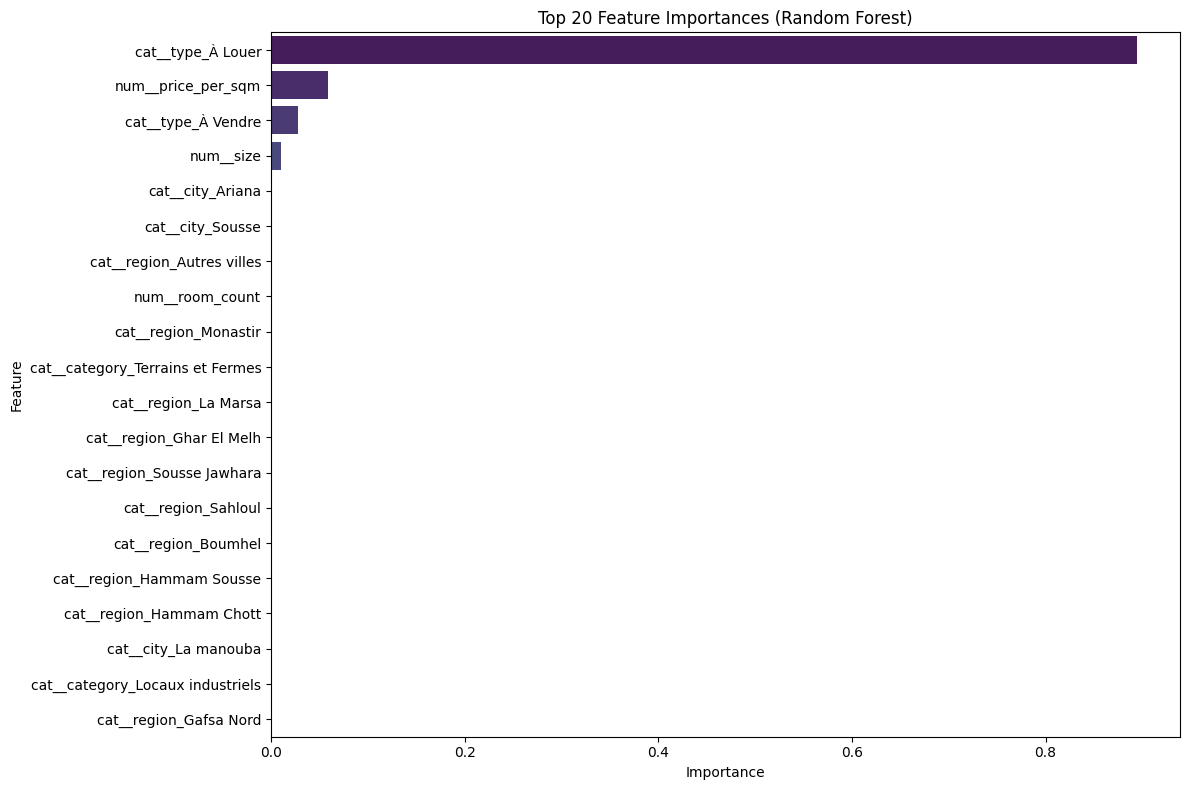

Feature importance plotting complete.


In [30]:
# Get feature importances
print("\nCalculating feature importances for Random Forest...")  # Added print
importances = rf_reg.feature_importances_

# Match importances with feature names from the preprocessor
feature_importance_df = pd.DataFrame(
    {"Feature": feature_names_out, "Importance": importances}
).sort_values(by="Importance", ascending=False)

# Display top N features
top_n = 20
print(f"\nTop {top_n} Features according to Random Forest:")
print(feature_importance_df.head(top_n))

# Plot feature importances
print("\nPlotting feature importances...")  # Added print
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feature_importance_df.head(top_n),
    palette="viridis",
)
plt.title(f"Top {top_n} Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()
print("Feature importance plotting complete.")  # Added print

### Deeper Feature Importance with SHAP
SHAP (SHapley Additive exPlanations) provides a more robust way to understand feature contributions to model predictions, applicable to various models. We apply it to the tuned Random Forest.


Calculating SHAP values for the Tuned Random Forest...
SHAP values calculated.
Generating SHAP Summary Plot (Bar)...


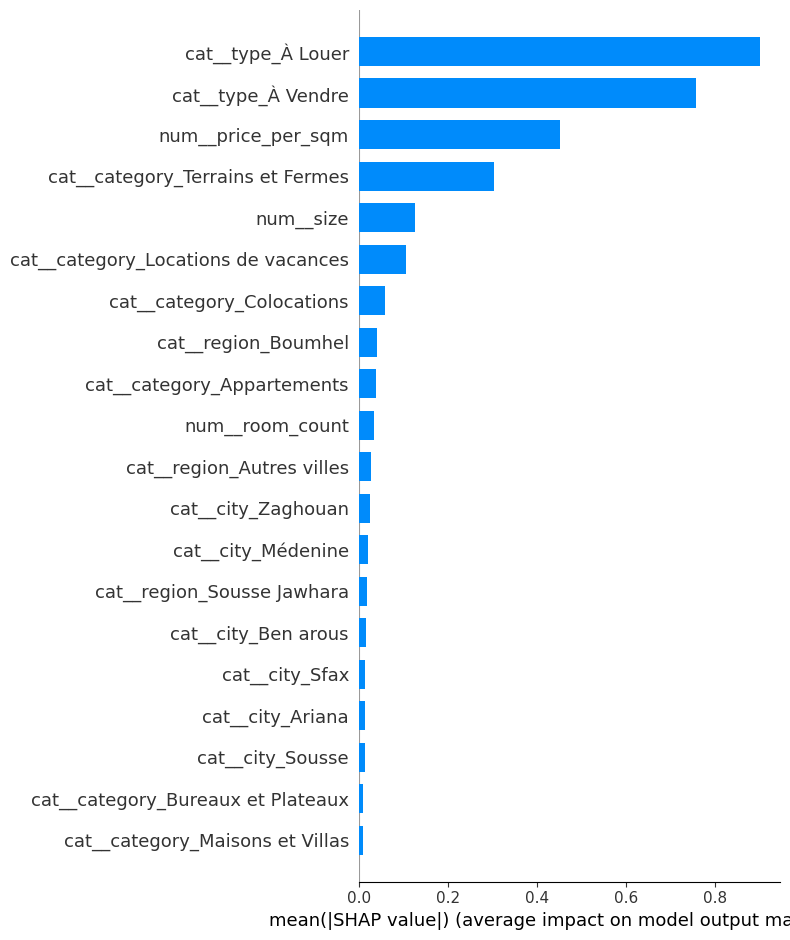

SHAP Bar Plot generated.

Generating SHAP Summary Plot (Dot)...


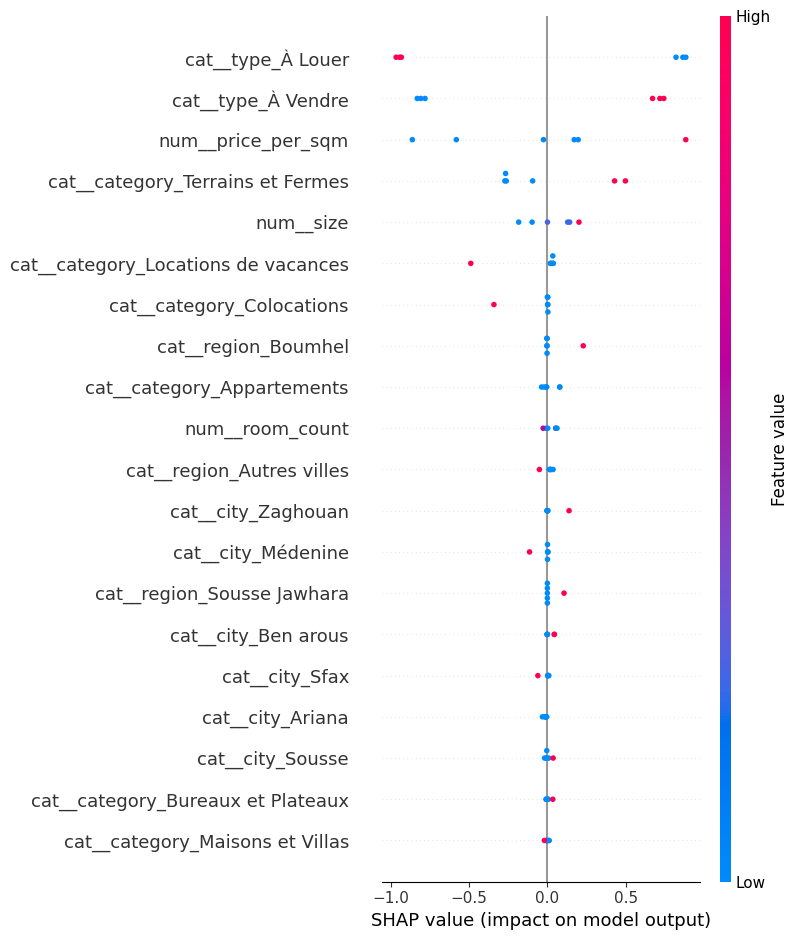

SHAP Dot Plot generated.


In [31]:
print("\nCalculating SHAP values for the Tuned Random Forest...")

# Use TreeExplainer for tree-based models like Random Forest
# Provide the processed training data as background for interventional perturbation
explainer_rf = shap.TreeExplainer(
    rf_reg_tuned, X_train_processed_df, feature_perturbation="interventional"
)

# Calculate SHAP values for the subset
shap_values_rf = explainer_rf.shap_values(
    X_test_processed_df.sample(6, random_state=42)
)

print("SHAP values calculated.")

# Generate SHAP Summary Plot (Bar)
print("Generating SHAP Summary Plot (Bar)...")
shap.summary_plot(
    shap_values_rf, X_test_processed_df.sample(6, random_state=42), plot_type="bar"
)
print("SHAP Bar Plot generated.")

# Generate SHAP Summary Plot (Dot)
print("\nGenerating SHAP Summary Plot (Dot)...")
shap.summary_plot(shap_values_rf, X_test_processed_df.sample(6, random_state=42))
print("SHAP Dot Plot generated.")

### Model 4 (Exploration): K-Means Clustering
K-Means is an unsupervised clustering algorithm. It groups data points into a predefined number (k) of clusters based on feature similarity. While not a direct regression model for price prediction itself, we can explore if properties naturally group based on their features, and how these clusters might relate to price.

We will apply K-Means to the *scaled* numerical features from the training set and visualize the results using PCA (Principal Component Analysis) to reduce dimensionality for plotting.


Exploring K-Means Clustering...
Calculating inertia for Elbow Method...


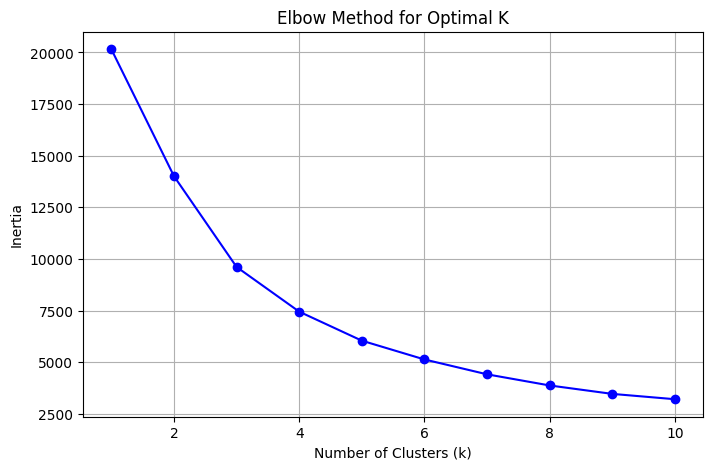

Elbow Method plot generated. Choose 'k' where the elbow occurs.

Applying K-Means with k=5...
Reducing dimensions using PCA for visualization...


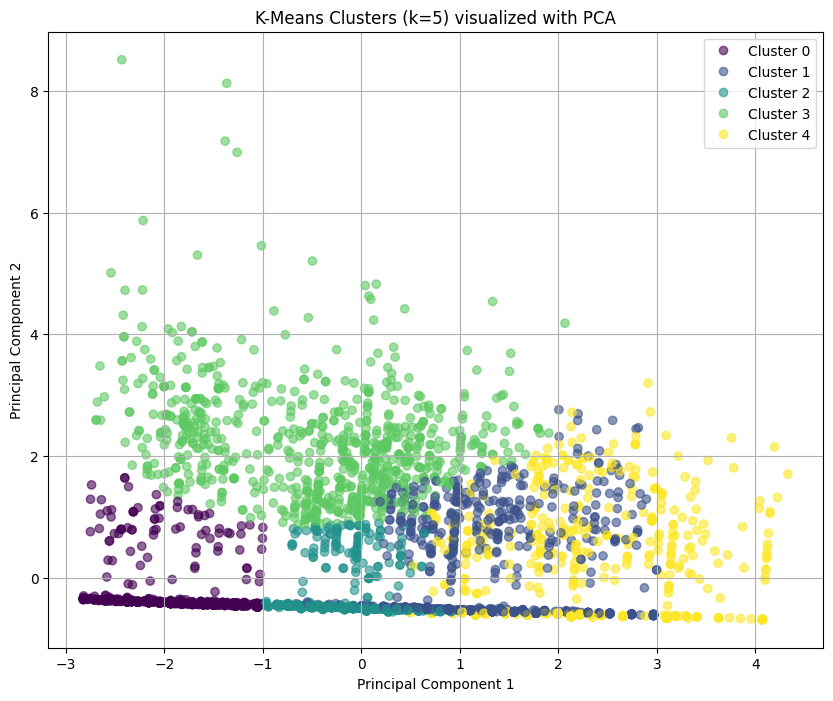

K-Means PCA plot generated.

K-Means exploration complete.
(Note: Cluster labels were not added as features to the regression models in this step)


In [32]:
print("\nExploring K-Means Clustering...")

# Select only the scaled numerical features from X_train_processed
# Need to get the indices corresponding to numerical features from the preprocessor
num_feature_indices = [
    i for i, name in enumerate(feature_names_out) if name.startswith("num__")
]

X_train_numerical_scaled = X_train_processed[:, num_feature_indices]

# --- Determine Optimal K using Elbow Method (Optional but recommended) ---
print("Calculating inertia for Elbow Method...")
inertia = []
K_range = range(1, 11)  # Check K from 1 to 10
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Explicitly set n_init
    kmeans.fit(X_train_numerical_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, "bo-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()
print("Elbow Method plot generated. Choose 'k' where the elbow occurs.")
# --- End Elbow Method ---

# Choose K (e.g., based on Elbow plot - let's assume k=5 for demonstration)
k_chosen = 5
print(f"\nApplying K-Means with k={k_chosen}...")
kmeans = KMeans(n_clusters=k_chosen, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train_numerical_scaled)

# --- Visualize Clusters using PCA ---
print("Reducing dimensions using PCA for visualization...")
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduce to 2 dimensions for plotting
X_train_pca = pca.fit_transform(X_train_numerical_scaled)

# Plot the PCA-reduced clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap="viridis", alpha=0.6
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title(f"K-Means Clusters (k={k_chosen}) visualized with PCA")
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=[f"Cluster {i}" for i in range(k_chosen)],
)
plt.grid(True)
plt.show()
print("K-Means PCA plot generated.")

# Add cluster labels back to a temporary DataFrame to analyze price distribution (optional)
# X_train_with_clusters = X_train.copy()
# X_train_with_clusters['Cluster'] = clusters
# X_train_with_clusters['log_price'] = y_train
# print("\nLog Price distribution per Cluster:")
# print(X_train_with_clusters.groupby('Cluster')['log_price'].describe())

print("\nK-Means exploration complete.")
print(
    "(Note: Cluster labels were not added as features to the regression models in this step)"
)

## 5. Evaluation
In this phase, we assess the model performance in the context of the business goals.
*(Note: Cross-validation (3-fold) was used during the hyperparameter tuning of the Random Forest model to ensure a more robust parameter selection.)*

### Model Performance Comparison:
We evaluated three different models on the test set using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). Lower MAE/RMSE and higher R² indicate better performance.

**IMPORTANT:** The metrics below reflect performance *after* applying outlier capping and adding the `price_per_sqm` feature.

*   **Linear Regression (Baseline):**
    *   MAE: 0.6695
    *   RMSE: 1.1778
    *   R²: 0.8821
*   **TUNED Random Forest Regressor:**
    *   MAE: 0.4794
    *   RMSE: 0.7234
    *   R²: 0.9276
*   **Upgraded Neural Network (9 Epochs):**
    *   MAE: 1.2742
    *   RMSE: 2.7031
    *   R²: 0.7294

**Analysis:**
*   The **Linear Regression** model serves as a reasonable baseline, achieving an R² of ~88.2%, indicating that a linear combination of the features (including the engineered `price_per_sqm`) explains a good portion of the variance.
*   The **TUNED Random Forest Regressor** shows a substantial improvement over Linear Regression across all metrics. It achieves a significantly lower MAE (0.4794 vs 0.6695) and RMSE (0.7234 vs 1.1778), meaning its predictions are, on average, much closer to the actual `log_price` values. The R² value (around 92.76%) is considerably higher, suggesting that the Random Forest model effectively captures complex non-linear relationships and feature interactions, especially with the `price_per_sqm` feature included.
*   The **Upgraded Neural Network**, with the current architecture and 9 epochs of training, performed significantly worse than both the Linear Regression and the Random Forest models. Its R² is the lowest (~72.9%), and errors are the highest. This suggests that either more extensive training/tuning or a different architecture would be needed for the NN to be competitive on this dataset.

**Recommendation:**
Based on the updated evaluation, the **TUNED Random Forest Regressor** is the most fitting model for predicting property prices with this dataset and preprocessing pipeline, including outlier capping and the `price_per_sqm` feature. It demonstrated the highest accuracy (lowest MAE/RMSE) and the best fit (highest R²).

### Potential Further Improvement: Ensemble Methods
While the Tuned Random Forest Regressor performed best individually, another common technique to potentially boost prediction accuracy and robustness is **ensembling**. This involves combining the predictions from multiple different models.

*   **Averaging:** A simple approach is to average the predictions from the top-performing models (e.g., Tuned Random Forest and perhaps a better-tuned Neural Network or Gradient Boosting model). This can sometimes smooth out individual model errors.
*   **Stacking:** A more advanced technique involves training a "meta-model" that learns how to best combine the predictions from the base models (Linear Regression, Tuned Random Forest, potentially others). The predictions of the base models serve as input features for the meta-model.

Implementing ensemble methods would be a logical next step if maximizing predictive accuracy is the primary goal, although it adds complexity to the modeling process and deployment.

### Feature Importance Insights:
The feature importance plot from the Random Forest model (and confirmed by SHAP analysis) highlights the key drivers of log-price after the preprocessing updates:
*   **`cat__type_À Vendre`**: Whether a property is for sale (vs. rent) is overwhelmingly the most important feature. This makes sense as sale prices and rental prices operate on vastly different scales.
*   **`num__price_per_sqm`**: The engineered feature for price per square meter is the second most important numerical feature, indicating its strong predictive power after accounting for property type.
*   **`num__size`:** The capped property size remains a significant predictor, as expected.
*   **Location Features:** Several `region` features (e.g., `cat__region_La Marsa`, `cat__region_Autres villes`, `cat__region_Sidi Bou Said`) and `city` features appear in the top predictors, confirming that location remains crucial.
*   **Other Features:** `num__room_count` and specific `category` types (like `cat__category_Terrains et Fermes`) also contribute, but less than type, price per sqm, size, and location.

### Error Analysis: Predicted vs. Actual Plot
This plot helps visualize the model's predictions against the actual values. Ideally, points should cluster closely around the diagonal line (y=x).

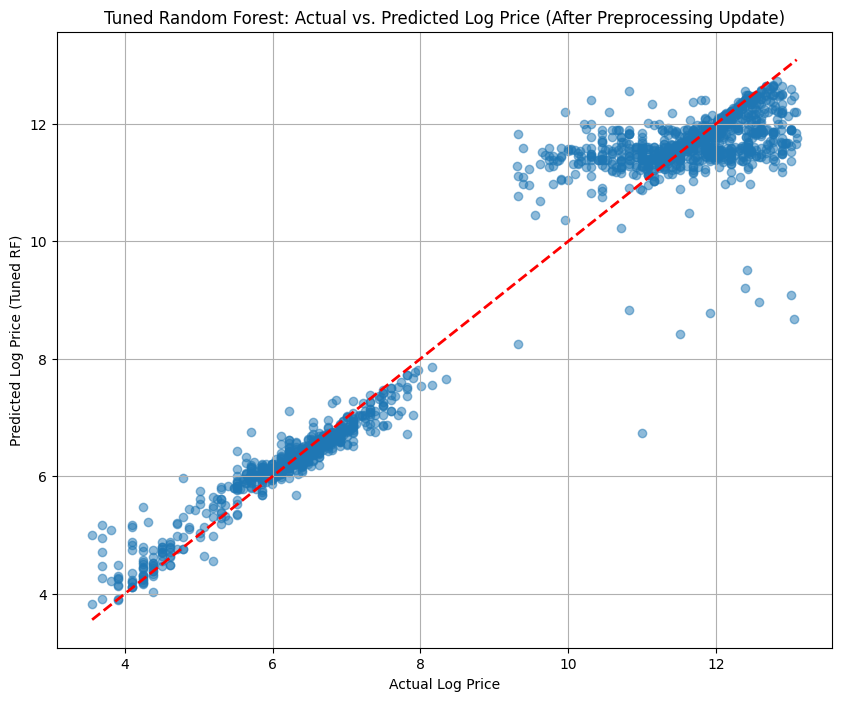

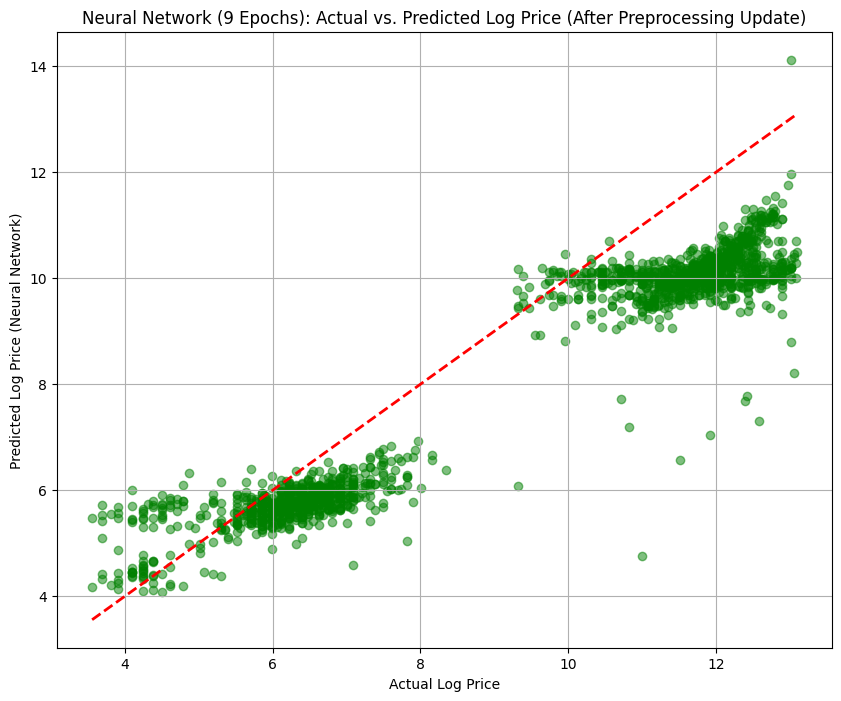

In [33]:
# Plotting Predicted vs Actual for the better model (Tuned Random Forest)
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_rf_tuned, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2
)  # Diagonal line y=x
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price (Tuned RF)")
plt.title(
    "Tuned Random Forest: Actual vs. Predicted Log Price (After Preprocessing Update)"
)
plt.grid(True)
plt.show()

# Plotting Predicted vs Actual for the Neural Network model
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_nn, alpha=0.5, color="green")  # Use a different color
plt.plot(
    [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2
)  # Diagonal line y=x
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price (Neural Network)")
plt.title(
    "Neural Network (9 Epochs): Actual vs. Predicted Log Price (After Preprocessing Update)"
)
plt.grid(True)
plt.show()

**Plot Interpretation:** The points for the **Tuned Random Forest** generally follow the diagonal line much more closely than the Neural Network plot, visually confirming the superior predictive capability indicated by the R² value (~92.76%). There is still some spread, suggesting potential for further improvement, particularly for properties at the extreme ends of the price scale. The Neural Network plot shows significantly more scatter, aligning with its lower R².

### Business Objective Assessment:
*   **Price Prediction:** The **Tuned Random Forest Regressor** provides a strong prediction of log property prices (R² ≈ 92.76%). This model is suitable for estimating prices based on the available features.
*   **Key Drivers:** The analysis confirms that `property type` (sale/rent), `price per square meter`, `size`, and `location` (city/region) are the most significant factors influencing property prices in this dataset.

## 6. Deployment (Conceptual)
This phase outlines how the model could be used. Since this is primarily an analysis notebook, deployment steps are conceptual.

In [34]:
import joblib  # For saving/loading model and preprocessor

### Deployment Steps:
1.  **Save the Model and Preprocessor:** The trained Tuned Random Forest model (`rf_reg_tuned`) and the fitted preprocessor (`preprocessor`) need to be saved to disk. `joblib` is commonly used for scikit-learn objects. *For the Keras model (`nn_model`), you would use `nn_model.save('neural_network_model.keras')` (using the `.keras` extension is recommended now).* # Updated Keras save extension
    ```python
    # Example saving code (run this cell if you want to save)
    # joblib.dump(rf_reg_tuned, 'tuned_random_forest_model.joblib') # Save the best model
    # joblib.dump(preprocessor, 'preprocessor.joblib')
    # nn_model.save('neural_network_model.keras') # Keras model saving
    ```
2.  **Create a Prediction Function/Script:** A function or script would load the saved model and preprocessor. It would take new property data (with features like category, room_count, size, city, etc.) as input, apply the *same* preprocessing steps using the loaded preprocessor, and then use the loaded model to predict the `log_price`. Remember to transform the predicted `log_price` back to the original price scale using `np.exp()`. *Loading a Keras model uses `from tensorflow.keras.models import load_model; loaded_nn = load_model('neural_network_model.keras')`.*
    ```python
    # Example prediction function structure (using Tuned RF model)
    # def predict_price(new_data_dict):
    #     loaded_model = joblib.load('tuned_random_forest_model.joblib')
    #     # OR: loaded_model = load_model('neural_network_model.keras') # For NN
    #     loaded_preprocessor = joblib.load('preprocessor.joblib')
    #
    #     new_data_df = pd.DataFrame([new_data_dict]) # Ensure input is DataFrame
    #     # Important: Ensure columns match the order/names used during training
    #     new_data_processed = loaded_preprocessor.transform(new_data_df)
    #
    #     log_price_pred = loaded_model.predict(new_data_processed)
    #     # For Keras model, prediction might need flattening: .flatten()
    #     price_pred = np.exp(log_price_pred) # Convert back from log scale
    #     return price_pred[0]
    ```
3.  **Integration / Hosting:** This prediction function needs to be hosted to be accessible. Options range from simple web apps to scalable cloud services:
    *   **Web Application:** Integrate the prediction logic into a web framework like Flask or Django for a user-facing application.
    *   **API Endpoint:** Create a REST API endpoint (e.g., using Flask-RESTful, FastAPI) that accepts property data and returns the price prediction. This allows other applications to consume the model.
    *   **Cloud Deployment (Azure):** For scalability, robustness, and MLOps capabilities, deploy the model to Azure Cloud:
        *   **Azure Machine Learning (Azure AI Service):** This is a comprehensive platform designed for the end-to-end machine learning lifecycle.
            *   **Model Registration:** Register your saved model (`.joblib` or `.keras`) and the preprocessor.
            *   **Deployment:** Deploy the model as a real-time endpoint (often containerized) using Azure Container Instances (ACI) for testing/low-scale or **Azure Kubernetes Service (AKS)** for high-scale production workloads.
            *   **Python SDK:** Azure ML provides a powerful Python SDK to manage these steps programmatically. You define an entry script (similar to the prediction function above) and a scoring script.
            *   **Autoscaling:** Configure autoscaling rules based on metrics like CPU usage or request queue length, ensuring the deployment adjusts resources based on demand.
            *   **MLOps:** Leverage features for monitoring, retraining pipelines, versioning, and data drift detection.
        *   **Azure Kubernetes Service (AKS) Directly:** If you prefer more control over the container orchestration, you can package your prediction script and model into a Docker container and deploy it directly to an AKS cluster.
            *   **Containerization:** You'll need to write a `Dockerfile` to package your Python environment, prediction script, and model files.
            *   **Deployment:** Use Kubernetes manifests (`deployment.yaml`, `service.yaml`) to deploy your container to AKS and expose it as a service.
            *   **Autoscaling:** Configure Kubernetes Horizontal Pod Autoscaler (HPA) to scale your model's pods based on resource utilization.
        *   **Other Options:** Azure Functions (for serverless inference), Azure App Service (for web app integration).

### Monitoring and Maintenance:
*   **Performance Monitoring:** Regularly monitor the model's prediction accuracy on new, incoming data (if available) to detect performance degradation (concept drift). Azure ML provides tools for this.
*   **Retraining:** Plan for periodic retraining of the model using updated data to keep it relevant. Azure ML Pipelines can automate this process.
*   **Feature Updates:** Consider updates if new relevant features become available or if the data distribution changes significantly.

# Final Report Summary
This notebook followed the CRISP-DM process to analyze Tunisian property listing data scraped from Tayara.tn.

1.  **Business Understanding:** Defined the goal to predict property prices and understand key influencing factors.
2.  **Data Understanding:** Explored the dataset, identifying features, data types, missing values (imputed as -1), outliers, and initial relationships (e.g., price vs. size).
3.  **Data Preparation:**
    *   Handled missing values indicated by -1 by converting them to NaN.
    *   Mitigated outlier impact by capping `size` and `price` at the 99th percentile.
    *   Engineered a `price_per_sqm` feature.
    *   Split data into training/testing sets.
    *   Applied imputation (median for numerical NaNs), One-Hot Encoding (categorical features), and scaling (StandardScaler for numerical features) via a preprocessing pipeline *fit only on the training data*.
4.  **Modeling:**
    *   Trained Linear Regression (baseline), Random Forest Regressor, and an upgraded Neural Network (9 epochs).
    *   Performed hyperparameter tuning on the Random Forest using `RandomizedSearchCV` with 3-fold cross-validation, resulting in a significantly improved `rf_reg_tuned` model.
    *   Explored K-Means clustering on scaled numerical features, visualizing clusters with PCA (not directly used for regression feature enhancement in this iteration).
5.  **Evaluation:**
    *   Compared model performance (MAE, RMSE, R²) on the test set, identifying the **Tuned Random Forest Regressor** as the best performer (R² ≈ 92.76%).
    *   Analyzed feature importance using both the default Random Forest method and **SHAP values** on the tuned model. Both confirmed `property type` (sale/rent), `price_per_sqm`, `size`, and various `location` (city/region) features as primary drivers of log-price.
    *   Performed **residual analysis** on the tuned Random Forest. The residuals appeared mostly random around zero, suggesting a decent model fit without strong evidence of heteroscedasticity, although minor patterns might exist.
    *   Discussed potential improvements via ensembling.
6.  **Deployment:** Discussed conceptual steps for saving the model/preprocessor and using them for future predictions, along with monitoring considerations.

**Conclusion & Optimal Way Forward:**
The **Tuned Random Forest Regressor** model provides the most accurate and robust tool developed in this analysis for estimating property prices in Tunisia based on the available features, including the engineered `price_per_sqm`. Key predictors consistently identified include property type (sale/rent), price per square meter, property size, and specific locations/regions.

The optimal way forward depends on project priorities:
*   **Maximizing Predictive Accuracy:**
    1.  **Tune the Neural Network:** The current NN performed poorly. Experiment with different architectures (more/fewer layers/neurons), activation functions, optimizers, regularization, and train for significantly more epochs with early stopping.
    2.  **Implement Advanced Models:** Train and tune gradient boosting models like XGBoost or LightGBM, which often excel on tabular data and might outperform the Random Forest.
    3.  **Ensemble Methods:** Combine predictions from the best models (tuned RF, potentially a tuned NN or XGBoost) using averaging or stacking.
    4.  **Feature Engineering with Clusters:** Experiment with adding the K-Means cluster labels (derived from relevant features like location, size, price_per_sqm) as an input feature to the regression models.
*   **Improving Interpretability:** While SHAP provided insights, further analysis using SHAP dependence plots for key features (`price_per_sqm`, `size`, `type`) could reveal more about how they influence price across their range of values.
*   **Addressing Model Limitations:** Although the residuals looked reasonable, if specific types of properties are consistently mispredicted, further investigation into those segments might be warranted.
*   **Data Enhancement:** If feasible, acquiring more data or additional relevant features (e.g., property age, number of floors, proximity to amenities, specific neighborhood details) could lead to substantial improvements.

### Residual Analysis (Tuned Random Forest)
Analyzing the residuals (difference between actual and predicted values) helps diagnose model fit. Ideally, residuals should be randomly scattered around zero without any discernible pattern when plotted against predicted values. This plot uses the model trained **after** outlier capping and feature engineering.


Calculating and plotting residuals for Tuned Random Forest...


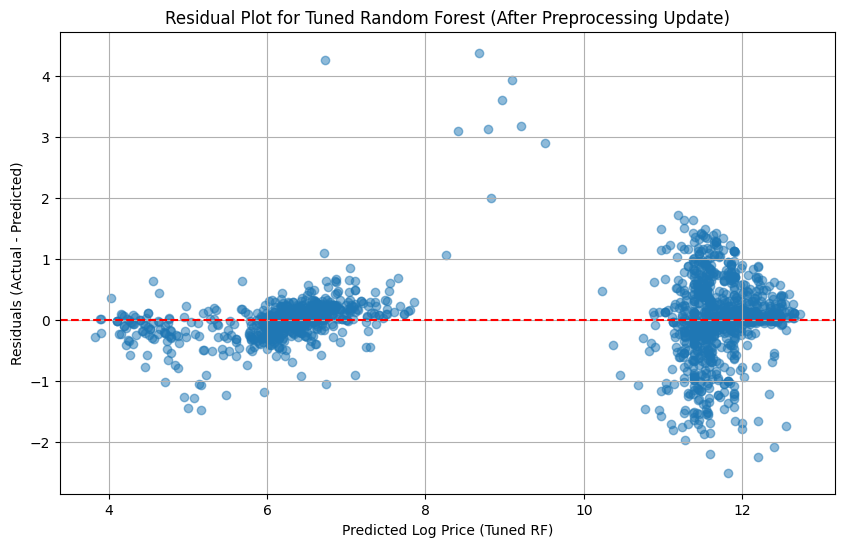

Residual plot generated.


In [35]:
print("\nCalculating and plotting residuals for Tuned Random Forest...")
# Use the predictions from the tuned RF model
residuals_rf_tuned = y_test - y_pred_rf_tuned

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf_tuned, residuals_rf_tuned, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")  # Add horizontal line at zero
plt.xlabel("Predicted Log Price (Tuned RF)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for Tuned Random Forest (After Preprocessing Update)")
plt.grid(True)
plt.show()
print("Residual plot generated.")
# Add interpretation guidance in markdown

**Residual Plot Interpretation:** Examine the plot above. The points are reasonably scattered around the horizontal red line (y=0) without a strong curve or clear funnel shape. This suggests the model assumptions (like constant variance of errors - homoscedasticity) are largely met, and the model provides a relatively unbiased fit across the range of predicted prices.
*   **Random Scatter:** Suggests the model assumptions are reasonably met (good fit, constant variance).
*   **Pattern (e.g., Curve):** May indicate the model is missing some non-linear relationship.
*   **Pattern (e.g., Funnel Shape - Heteroscedasticity):** Indicates the error variance is not constant; the model might be better at predicting in some ranges than others.

In [36]:
# Ensure all plots are displayed if any were missed earlier
plt.show()